In [1]:
from importlib import reload
import backtest
import order_book
import signal_1

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf

In [3]:
tickers = ['TSM', 'TSMC34.SA']
colnames = ["Close", "Volume"]
combined=pd.DataFrame()
for ticker in tickers:
    ts = yf.Ticker(ticker)
    data = ts.history(interval="1D", period="4y")[["Close", "Volume"]]
    data.rename(columns = dict(zip(colnames, [  ticker.replace(".", "_") + "_" + col for col in colnames])), inplace=True)
    data.index = [dt.datetime.strptime(x, "%m-%d-%y") for x in data.index.strftime('%m-%d-%y')]
    if len(colnames)==0:
        combined = data.copy()
    else:
        combined = pd.concat([combined, data.copy()], axis = 1)
    colnames.append(ticker)
combined

,TSM_Close,TSM_Volume,TSMC34_SA_Close,TSMC34_SA_Volume
2020-07-13,60.490005,16667700.0,40.825260,17920.0
2020-07-14,62.246967,10482700.0,42.328320,1760.0
2020-07-15,61.410320,12432500.0,40.987343,80.0
2020-07-16,61.903008,15709400.0,40.731968,10400.0
2020-07-17,61.726387,11716600.0,41.745285,800.0
...,...,...,...,...
2024-07-08,186.630005,22582400.0,127.760002,103869.0
2024-07-09,184.520004,19935200.0,125.290001,85916.0
2024-07-10,191.050003,19293500.0,129.610001,116218.0
2024-07-11,184.500000,21501700.0,124.949997,143469.0


In [4]:
combined = combined.reset_index().rename(columns={'Datetime':'Date'})
combined

,index,TSM_Close,TSM_Volume,TSMC34_SA_Close,TSMC34_SA_Volume
0,2020-07-13,60.490005,16667700.0,40.825260,17920.0
1,2020-07-14,62.246967,10482700.0,42.328320,1760.0
2,2020-07-15,61.410320,12432500.0,40.987343,80.0
3,2020-07-16,61.903008,15709400.0,40.731968,10400.0
4,2020-07-17,61.726387,11716600.0,41.745285,800.0
...,...,...,...,...,...
1028,2024-07-08,186.630005,22582400.0,127.760002,103869.0
1029,2024-07-09,184.520004,19935200.0,125.290001,85916.0
1030,2024-07-10,191.050003,19293500.0,129.610001,116218.0
1031,2024-07-11,184.500000,21501700.0,124.949997,143469.0


In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
## analysis between adr spread and volume pct
df = combined[:-30]

df.fillna(method='ffill', inplace=True)
df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_Volume'] +df['TSM_Volume'])
mean = df['ADR_Vol_Pct'].mean()
std = df['ADR_Vol_Pct'].std()
df['ADR_Vol_Pct'] = (df['ADR_Vol_Pct'] - mean)/std
df['ADR_Spread'] = df['TSM_Close'] - df['TSMC34_SA_Close']
mean = df['ADR_Spread'].mean()
std = df['ADR_Spread'].std()
df['ADR_Spread'] = (df['ADR_Spread'] - mean)/std
coint_test_result = coint_johansen(df[['ADR_Vol_Pct','ADR_Spread']], det_order=0, k_ar_diff=1)
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt
for i, (stock1, stock2) in enumerate([('ADR_Vol_Pct', 'ADR_Spread')]):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

Pair 1 (ADR_Vol_Pct and ADR_Spread) is cointegrated.


C:\Users\raymo\AppData\Local\Temp\ipykernel_30540\1430338049.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\raymo\AppData\Local\Temp\ipykernel_30540\1430338049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)
C:\Users\raymo\AppData\Local\Temp\ipykernel_30540\1430338049.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_

In [28]:
import statsmodels.api as sm
# adding the constant term
x = df[['ADR_Spread']].shift(1)[1:]#.tolist()
y = df['ADR_Spread'][1:].tolist()
#x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()
 
# printing the summary table
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          2.729e+04
Date:                Fri, 12 Jul 2024   Prob (F-statistic):                        0.00
Time:                        16:33:19   Log-Likelihood:                          254.36
No. Observations:                1002   AIC:                                     -506.7
Df Residuals:                    1001   BIC:                                     -501.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [27]:
result.coef()

AttributeError: 'OLSResults' object has no attribute 'coef'

In [5]:

df['ADR_Vol_MA20'] = df['ADR_Vol_Pct'].rolling(20).mean()
df['ADR_1sd_MA20'] = df['ADR_Vol_Pct'].rolling(20).std()
df['primitive_signal'] = df.apply(lambda dr: 1 if dr.ADR_Vol_Pct < dr.ADR_Vol_MA20 - dr.ADR_1sd_MA20 else 0, axis=1).rolling(5).mean()
## add persistence to signal - to optimize
df['Signal'] = [1 if x > 0 else 0 for x in df['primitive_signal']]
df['BuySell'] = df['Signal'] - df['Signal'].shift(1)
df["index"] = pd.to_datetime(df["index"])
df

C:\Users\raymo\AppData\Local\Temp\ipykernel_30540\2952733651.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\raymo\AppData\Local\Temp\ipykernel_30540\2952733651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)
C:\Users\raymo\AppData\Local\Temp\ipykernel_30540\2952733651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_

,index,TSM_Close,TSM_Volume,TSMC34_SA_Close,TSMC34_SA_Volume,ADR_Vol_Pct,ADR_Vol_MA20,ADR_1sd_MA20,primitive_signal,Signal,BuySell
0,2020-07-13,60.490005,16667700.0,40.825260,17920.0,0.001074,NaN,NaN,NaN,0,NaN
1,2020-07-14,62.246967,10482700.0,42.328320,1760.0,0.000168,NaN,NaN,NaN,0,0.0
2,2020-07-15,61.410320,12432500.0,40.987343,80.0,0.000006,NaN,NaN,NaN,0,0.0
3,2020-07-16,61.903008,15709400.0,40.731968,10400.0,0.000662,NaN,NaN,NaN,0,0.0
4,2020-07-17,61.726387,11716600.0,41.745285,800.0,0.000068,NaN,NaN,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
998,2024-05-27,159.496826,11895500.0,109.486778,82395.0,0.006879,0.003923,0.002380,0.0,0,0.0
999,2024-05-28,158.908676,13964400.0,102.333977,184375.0,0.013031,0.004453,0.003101,0.0,0,0.0
1000,2024-05-29,153.854614,15780000.0,100.358719,66726.0,0.004211,0.004557,0.003054,0.0,0,0.0
1001,2024-05-30,152.478973,9711000.0,100.358719,66726.0,0.006824,0.004774,0.003053,0.0,0,0.0


In [68]:
BBO = order_book.Book()
for row in df.itertuples():
    if (row.BuySell == 1):
        print('bought spread at ', row.index)
        BBO.addOrder(row.index, "TSM", row.TSM_Close, -100)
        BBO.addOrder(row.index, "TSMC34_SA", row.TSMC34_SA_Close, 150)
    elif (row.BuySell == -1):
        print('sold spread at ', row.index)
        BBO.addOrder(row.index, "TSM", row.TSM_Close, 100)
        BBO.addOrder(row.index, "TSMC34_SA", row.TSMC34_SA_Close, -150)
#BBO.addOrder(df_res.iloc[100]["Date"], "TSM", 300.0, 10)
#BBO.addOrder(df_res.iloc[120]["Date"], "TSM", 250.0, 25)
#BBO.addOrder(df_res.iloc[200]["Date"], "TSM", 350.0, -30)
#BBO.getTickerBook(["TSLA"]).tail(1)#.loc['Quantity']
#BBO.get_history()

#BBO.addOrder(df_res.iloc[50]["Date"], "TSMC34.SA", 300.0, 10)
#BBO.addOrder(df_res.iloc[150]["Date"], "TSMC34.SA", 250.0, -25)

bought spread at  2021-05-21 00:00:00
sold spread at  2021-05-28 00:00:00
bought spread at  2021-06-17 00:00:00
sold spread at  2021-07-05 00:00:00
bought spread at  2021-07-23 00:00:00
sold spread at  2021-08-05 00:00:00
bought spread at  2021-10-06 00:00:00
sold spread at  2021-10-13 00:00:00
bought spread at  2021-12-02 00:00:00
sold spread at  2021-12-09 00:00:00
bought spread at  2021-12-15 00:00:00
sold spread at  2021-12-29 00:00:00
bought spread at  2022-02-18 00:00:00
sold spread at  2022-02-28 00:00:00
bought spread at  2022-04-12 00:00:00
sold spread at  2022-05-05 00:00:00
bought spread at  2022-06-15 00:00:00
sold spread at  2022-06-23 00:00:00
bought spread at  2022-06-30 00:00:00
sold spread at  2022-07-18 00:00:00
bought spread at  2022-07-19 00:00:00
sold spread at  2022-07-26 00:00:00
bought spread at  2022-08-03 00:00:00
sold spread at  2022-08-11 00:00:00
bought spread at  2023-03-15 00:00:00
sold spread at  2023-03-22 00:00:00
bought spread at  2023-06-07 00:00:00


In [69]:
BBO.getHistoryDf().Date

0    2021-05-21
1    2021-05-21
2    2021-05-28
3    2021-05-28
4    2021-06-17
        ...    
67   2024-05-03
68   2024-05-06
69   2024-05-06
70   2024-05-16
71   2024-05-16
Name: Date, Length: 72, dtype: datetime64[ns]

In [70]:
df = df.rename(columns={"index":"Date"})
df1 = df[['Date', 'TSMC34_SA_Close']]
df2 = df[['Date', 'TSM_Close']]
df1['Ticker'] = 'TSMC34_SA'
df2['Ticker'] = 'TSM'

df_res = pd.concat([df1.rename(columns={'TSMC34_SA_Close':'Price'}),df2.rename(columns={'TSM_Close':'Price'})])
print(df_res)
#df1.drop('index', inplace=True)
#df_res.rename(columns={'Datetime':'Date'}, inplace=True)
df_res# = df1[['Date', 'Ticker']]
BBO.backfillPnL(df_res)

           Date       Price     Ticker
0    2020-07-10   39.670841  TSMC34_SA
1    2020-07-13   40.825256  TSMC34_SA
2    2020-07-14   42.328320  TSMC34_SA
3    2020-07-15   40.987328  TSMC34_SA
4    2020-07-16   40.731976  TSMC34_SA
...         ...         ...        ...
997  2024-05-23  156.595978        TSM
998  2024-05-24  159.496826        TSM
999  2024-05-27  159.496826        TSM
1000 2024-05-28  158.908676        TSM
1001 2024-05-29  153.854614        TSM

[2004 rows x 3 columns]


C:\Users\raymo\AppData\Local\Temp\ipykernel_47636\625089372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Ticker'] = 'TSMC34_SA'
C:\Users\raymo\AppData\Local\Temp\ipykernel_47636\625089372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Ticker'] = 'TSM'


In [71]:
hist = BBO.getHistoryDf()

In [72]:
BBO.getTickerBook(['TSM'])

,Date,Ticker,Quantity,CostBasis,MV,UnrealizedPnL,Cash
70,2024-05-16,TSM,0,0.0,0.0,-937.042236,-1647.833252


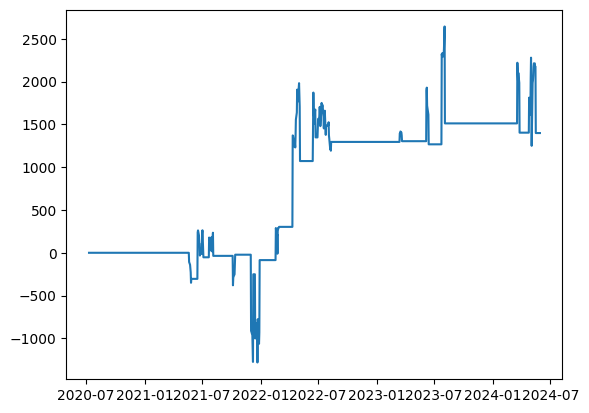

In [73]:
plt.plot(hist[['PnL']])
plt.show()

In [74]:
print(hist)

            CostBasis  Value          PnL         Cash
Date                                                  
2020-07-10        0.0    0.0     0.000000     0.000000
2020-07-13        0.0    0.0     0.000000     0.000000
2020-07-14        0.0    0.0     0.000000     0.000000
2020-07-15        0.0    0.0     0.000000     0.000000
2020-07-16        0.0    0.0     0.000000     0.000000
...               ...    ...          ...          ...
2024-05-23        0.0    0.0  1399.485207  1399.485207
2024-05-24        0.0    0.0  1399.485207  1399.485207
2024-05-27        0.0    0.0  1399.485207  1399.485207
2024-05-28        0.0    0.0  1399.485207  1399.485207
2024-05-29        0.0    0.0  1399.485207  1399.485207

[1002 rows x 4 columns]


In [75]:
BBO.get_books()

,Date,Ticker,Quantity,CostBasis,MV,UnrealizedPnL,Cash
0,2021-05-21,TSM,-100,-10535.062408,-10535.062408,0.000000,10535.062408
1,2021-05-21,TSMC34_SA,150,10642.684937,10642.684937,0.000000,-10642.684937
2,2021-05-28,TSM,0,0.000000,0.000000,-518.981171,-518.981171
3,2021-05-28,TSMC34_SA,0,0.000000,0.000000,214.272308,214.272308
4,2021-06-17,TSM,-100,-11262.857056,-11262.857056,0.000000,10743.875885
...,...,...,...,...,...,...,...
67,2024-05-03,TSMC34_SA,0,0.000000,0.000000,342.676163,1960.929680
68,2024-05-06,TSM,-100,-14238.082886,-14238.082886,0.000000,13527.291870
69,2024-05-06,TSMC34_SA,150,13503.535080,13503.535080,0.000000,-11542.605400
70,2024-05-16,TSM,0,0.000000,0.000000,-937.042236,-1647.833252


In [76]:
hist

,CostBasis,Value,PnL,Cash
Date,,,,
2020-07-10,0.0,0.0,0.000000,0.000000
2020-07-13,0.0,0.0,0.000000,0.000000
2020-07-14,0.0,0.0,0.000000,0.000000
2020-07-15,0.0,0.0,0.000000,0.000000
2020-07-16,0.0,0.0,0.000000,0.000000
...,...,...,...,...
2024-05-23,0.0,0.0,1399.485207,1399.485207
2024-05-24,0.0,0.0,1399.485207,1399.485207
2024-05-27,0.0,0.0,1399.485207,1399.485207
